/Users/sunandclouds/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


average accuracy 0.87543
0.81
0.81 1.0
0 0.0
0.8775
0.91 0.95
0.72 0.58


1it [00:10, 10.17s/it]

ensemble accuracy 0.8458333333333333


2it [00:20,  9.98s/it]

ensemble accuracy 0.8958333333333334


3it [00:29,  9.96s/it]

ensemble accuracy 0.8791666666666667


4it [00:39,  9.92s/it]

ensemble accuracy 0.9166666666666666


5it [00:49,  9.93s/it]

ensemble accuracy 0.8958333333333334


(array([ 1.,  9.,  9., 19., 21., 69., 68., 33., 17.,  4.]),
 array([0.8525, 0.8565, 0.8605, 0.8645, 0.8685, 0.8725, 0.8765, 0.8805,
        0.8845, 0.8885, 0.8925]),
 <BarContainer object of 10 artists>)

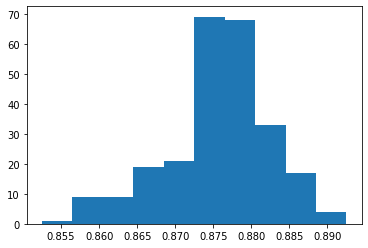

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["figure.dpi"] = 100

# Load the dataset
file_path = 'training_data.csv'
data = pd.read_csv(file_path)
data['increase_stock_binary'] = data['increase_stock'].apply(lambda x: 1 if x == 'high_bike_demand' else 0)
data = data.drop(["increase_stock"], axis=1)

X = data.to_numpy()
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

y = X[:,-1].astype(np.float32)
X = X[:,:-1].astype(np.float32)

metric = lambda a, b: (a == b).mean()

def RandomForestEnsemble(x, models):
    predictions = [model.predict_proba(x) for model in models]
    proba1 = np.mean(predictions, axis=0)[:, 1] # probability of predicting label 1
    return proba1.round() # [0,0,0,1,0,1,0,0,0,...]

def compute_precision(predictions, labels, positive_label=1):
    TP = ((predictions == positive_label) & (labels == positive_label)).sum().item()
    FP = ((predictions == positive_label) & (labels != positive_label)).sum().item()
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def compute_recall(predictions, labels, positive_label=1):
    TP = ((predictions == positive_label) & (labels == positive_label)).sum().item()
    FN = ((predictions != positive_label) & (labels == positive_label)).sum().item()
    return TP / (TP + FN) if (TP + FN) > 0 else 0

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0, shuffle=True)

seeds = range(50)
scores = []
models = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for s in seeds:
    # Note how the indices between the validation set and train set are flipped.
    # This means that the classifier will be trained on less than 50% of the data.
    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        clf = RandomForestClassifier(
            n_estimators=200, max_depth=100, criterion="entropy",
            random_state=s, n_jobs=-1
        )
        clf.fit(X_train[train_index], y_train[train_index])
        # accuracy = clf.score(X_train[test_index], y_train[test_index])
        accuracy = clf.score(X_test, y_test)
        scores.append(accuracy)
        models.append(clf)

print("average accuracy", np.mean(scores))

X_pred = RandomForestEnsemble(X_test, models)
metric(X_pred, y_test)

X_pred = np.zeros(len(y_test))
print(metric(X_pred, y_test))
for positive_label in [0, 1]:
    recall = compute_recall(X_pred, y_test, positive_label)
    precision = compute_precision(X_pred, y_test, positive_label)
    print(round(precision, 2), round(recall, 2))

X_pred = RandomForestEnsemble(X_test, models)
print(metric(X_pred, y_test))
for positive_label in [0, 1]:
    recall = compute_recall(X_pred, y_test, positive_label)
    precision = compute_precision(X_pred, y_test, positive_label)
    print(round(precision, 2), round(recall, 2))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0, shuffle=True)

clf = RandomForestClassifier(
    n_estimators=200, max_depth=100, criterion="entropy", oob_score=True,
    random_state=0, n_jobs=-1
)

clf.fit(X_train, y_train)

seeds = range(10)
# kf = StraKFold(5, random_state=0, shuffle=True)

for i, (train_index, test_index) in tqdm(enumerate(kf.split(X_train, y_train))):
    X_, X_test = X[train_index], X[test_index]
    y_, y_test = y[train_index], y[test_index]
    models = []
    
    # This loop creates a list of 3 * seeds classifiers using Bagging,
    # by splitting the training set into 3 sets. 
    for s in seeds:
        # Note how the indices between the validation set and train set are flipped.
        # This means that the classifier will be trained on less than 50% of the data.
        for i, (train_index_, _) in enumerate(KFold(n_splits=3).split(X_)):
            X_train = X_[train_index_]
            y_train = y_[train_index_]
            clf = RandomForestClassifier(
                n_estimators=200, max_depth=100, criterion="entropy",
                random_state=s, n_jobs=-1
            )
            clf.fit(X_train, y_train)
            models.append(clf)

    X_pred = RandomForestEnsemble(X_test, models)
    print("ensemble accuracy", metric(X_pred, y_test))

plt.hist(scores)